In [41]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [42]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [44]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [45]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [46]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [47]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [48]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [49]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


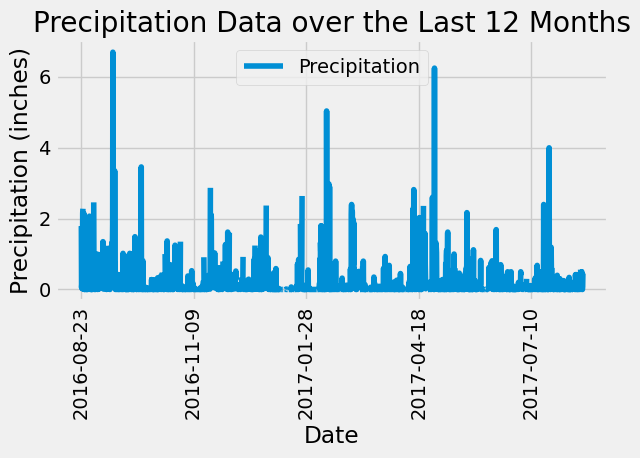

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= func.strftime('%Y-%m-%d', func.date(most_recent_date, '-365 day'))).\
    filter(measurement.date <= func.date(most_recent_date)).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Data over the Last 12 Months")
plt.tight_layout()
plt.show()

In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [52]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.station)).scalar()
station_count

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# Print the stations and their counts in descending order
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

# Print the temperature statistics using the query result
print(f"Temperature Statistics for Station {temperature_stats.station}:")
print(f"Lowest Temperature: {temperature_stats[1]} F")
print(f"Highest Temperature: {temperature_stats[2]} F")
print(f"Average Temperature: {temperature_stats[3]} F")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


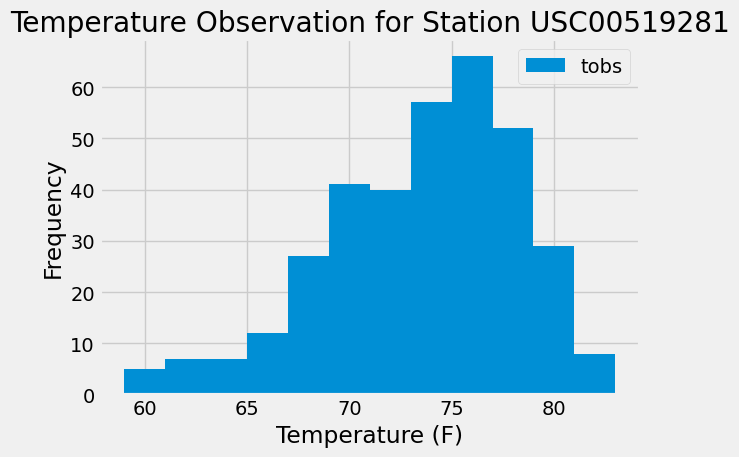

In [55]:
# Query to find the most active station
most_active_station = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

# Retrieve the most active station ID directly from the query result
most_active_station_id = most_active_station[0]

# Query the last 12 months of temperature observation data for the most active station
last_12_months = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= (datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365))).all()

# Create a Pandas DataFrame from the query result
active_station_df = pd.DataFrame(last_12_months, columns=['tobs'])

# Plot the histogram
plt.hist(active_station_df['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation for Station {most_active_station_id}')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [56]:
# Close Session
session.close()